In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from PhicoreModules import parse_genbank, median, mean, stdev, mode
from PhicoreModules import get_features_of_type
from PhicoreModules import get_features_lengths, get_gc_content, get_coding_density, get_distribution_of_stops
from PhicoreModules import write_df_to_artemis

# Testing functions

In [7]:
infiles = glob.glob('./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1*.gbk')
outdir = 'tmp'
if not os.path.exists(outdir): os.mkdir(outdir)

print("=== Some basic statistics ===")
for infile in infiles[:1]:
    print("Input file: {}".format(os.path.basename(infile)))
    for record in parse_genbank(infile):
        print("Stats for {} ({} bp)".format(record.id, len(record.seq)))
        print("GC content: {}".format(get_gc_content(record.seq)))
        cdss = get_features_of_type(record, 'CDS')
        print("Number of CDS: {}".format(len(cdss)))
        cdss_lengths = get_features_lengths(record, 'CDS')
        print("Average CDS length: {}".format(mean(cdss_lengths)))
        print("Median CDS length: {}".format(median(cdss_lengths)))
        print("Average coding density: {}".format(get_coding_density(record)))
        df = get_distribution_of_stops(record, window=210, step=1)
        df_stops_file = os.path.join(outdir, '{}.{}_stops.csv'.format(os.path.basename(infile), record.id))
        print("Writing distribution of stops to {}".format(df_stops_file))
        write_df_to_artemis(df, df_stops_file)

print("=== Average coding densities ===")
for infile in infiles:
    for record in parse_genbank(infile):
        print("{} - {}: {}".format(os.path.basename(infile), record.id, get_coding_density(record, ['CDS', 'tRNA'])))

=== Some basic statistics ===
Input file: UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk
Stats for MZ130495.1 (101130 bp)
GC content: 0.3295164639572827
Number of CDS: 143
Average CDS length: 225.27972027972027
Median CDS length: 120.0
Average coding density: 0.9494116483733808


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


Writing distribution of stops to tmp/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk.MZ130495.1_stops.csv
=== Average coding densities ===
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk - MZ130495.1: 0.9494116483733808
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TAA.gbk - MZ130495.1: 0.8097399386927717
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TGA-TAA.gbk - MZ130495.1: 0.780263027786018
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TGA.gbk - MZ130495.1: 0.8836843666567784
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG.gbk - MZ130495.1: 0.9336003164244042
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TGA-TAA.gbk - MZ130495.1: 0.9516760605161673
UAG-readthrough_crAss_clade_sp._strain_cr150_1-TGA.gbk - MZ130495.1: 0.9766933649757737


## Create plots of STOP codons distributions

=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk ===
Writing distribution of stops to tmp/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk.MZ130495.1_stops.png


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


Writing plot of the distribution to tmp/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAA.gbk.MZ130495.1_stops.png
=== Working on file ./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TAA.gbk ===
Writing distribution of stops to tmp/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TAA.gbk.MZ130495.1_stops.png


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


Writing plot of the distribution to tmp/UAG-readthrough_crAss_clade_sp._strain_cr150_1-TAG-TAA.gbk.MZ130495.1_stops.png


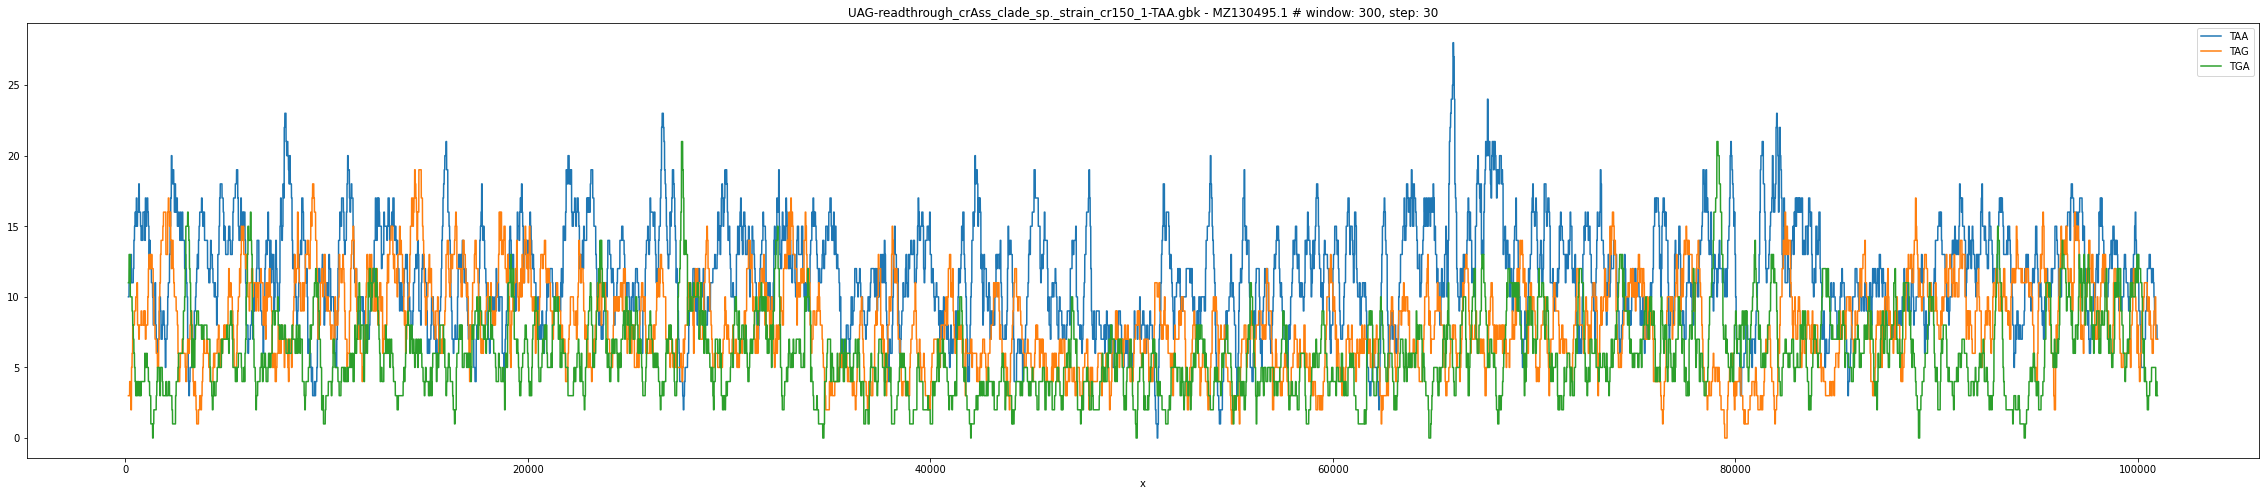

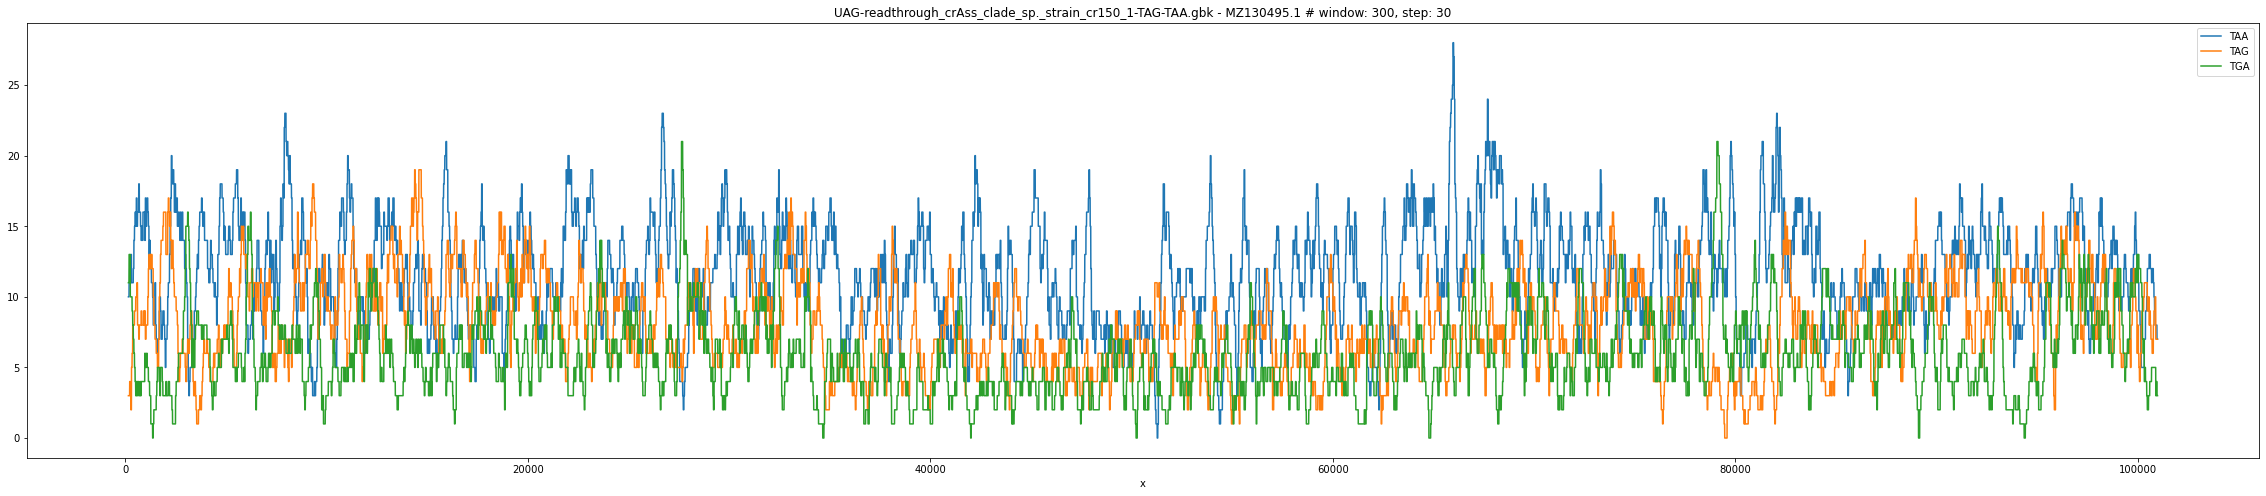

In [8]:
infiles = glob.glob('./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1*.gbk')
for infile in infiles[:2]:
    print("=== Working on file {} ===".format(infile))
    for record in parse_genbank(infile):
        # output files
        df_stops_file = os.path.join(outdir, '{}.{}_stops.png'.format(os.path.basename(infile), record.id))
        df_stops_plot_file = os.path.join(outdir, '{}.{}_stops.png'.format(os.path.basename(infile), record.id))
        # data
        window = 300
        step = 30
        df = get_distribution_of_stops(record, window, step)
        df.plot(
            x="x", 
            y=["TAA", "TAG", "TGA"], 
            figsize=(40, 8), 
            legend=True, 
            title="{} - {} # window: {}, step: {}".format(os.path.basename(infile), record.id, window, step)
        )
        print("Writing distribution of stops to {}".format(df_stops_file))
        write_df_to_artemis(df, df_stops_file)
        print("Writing plot of the distribution to {}".format(df_stops_plot_file))
        plt.savefig(df_stops_plot_file)

In [ ]:
def get_entropy_of_stops_per_frame(seqiorec, window=210, step=1):
    """
    Get distribution of stops
    :param seqiorec:
    :param window:
    :param step:
    :return:
    """

    stops = ['TAA', 'TAG', 'TGA']

    stops_frame_distr = {
        'frame1': {
            'x': range(1, len(seqiorec.seq) + 1),
            'TAA': [np.NAN]*int(window/2),
            'TAG': [np.NAN]*int(window/2),
            'TGA': [np.NAN]*int(window/2)
        },
        'frame2': {
            'x': range(1, len(seqiorec.seq) + 1),
            'TAA': [np.NAN]*int(window/2),
            'TAG': [np.NAN]*int(window/2),
            'TGA': [np.NAN]*int(window/2)
        },
        'frame3': {
            'x': range(1, len(seqiorec.seq) + 1),
            'TAA': [np.NAN]*int(window/2),
            'TAG': [np.NAN]*int(window/2),
            'TGA': [np.NAN]*int(window/2)
        },
    }
    
    i = 0
    while i + window/2 + 1 <= len(seqiorec.seq) - window/2:
        window_seq = seqiorec.seq[i : i + window]
        taa = window_seq.count('TAA')
        tag = window_seq.count('TAG')
        tga = window_seq.count('TGA')
        stops_distr['TAA'].extend([taa]*(step))
        stops_distr['TAG'].extend([tag]*(step))
        stops_distr['TGA'].extend([tga]*(step))
        i += step
        
    i -= step
    left = len(seqiorec.seq) - len(stops_distr['TAA'])
    if left > 0:   
        stops_distr['TAA'].extend([np.NAN]*left)
        stops_distr['TAG'].extend([np.NAN]*left)
        stops_distr['TGA'].extend([np.NAN]*left)

    return pd.DataFrame(stops_distr)